**Data Set**  
$$X_{train} \in \mathcal{R}^{50000 \times 784}, Y_{train} \in \mathcal{Z}^{50000}$$  
$$X_{val} \in \mathcal{R}^{10000 \times 784}, Y_{val} \in \mathcal{Z}^{10000}$$  
$$X_{test} \in \mathcal{R}^{10000 \times 784}, Y_{test} \in \mathcal{Z}^{10000}$$

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn


batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

50000 10000 10000


### Inspecting Dataset

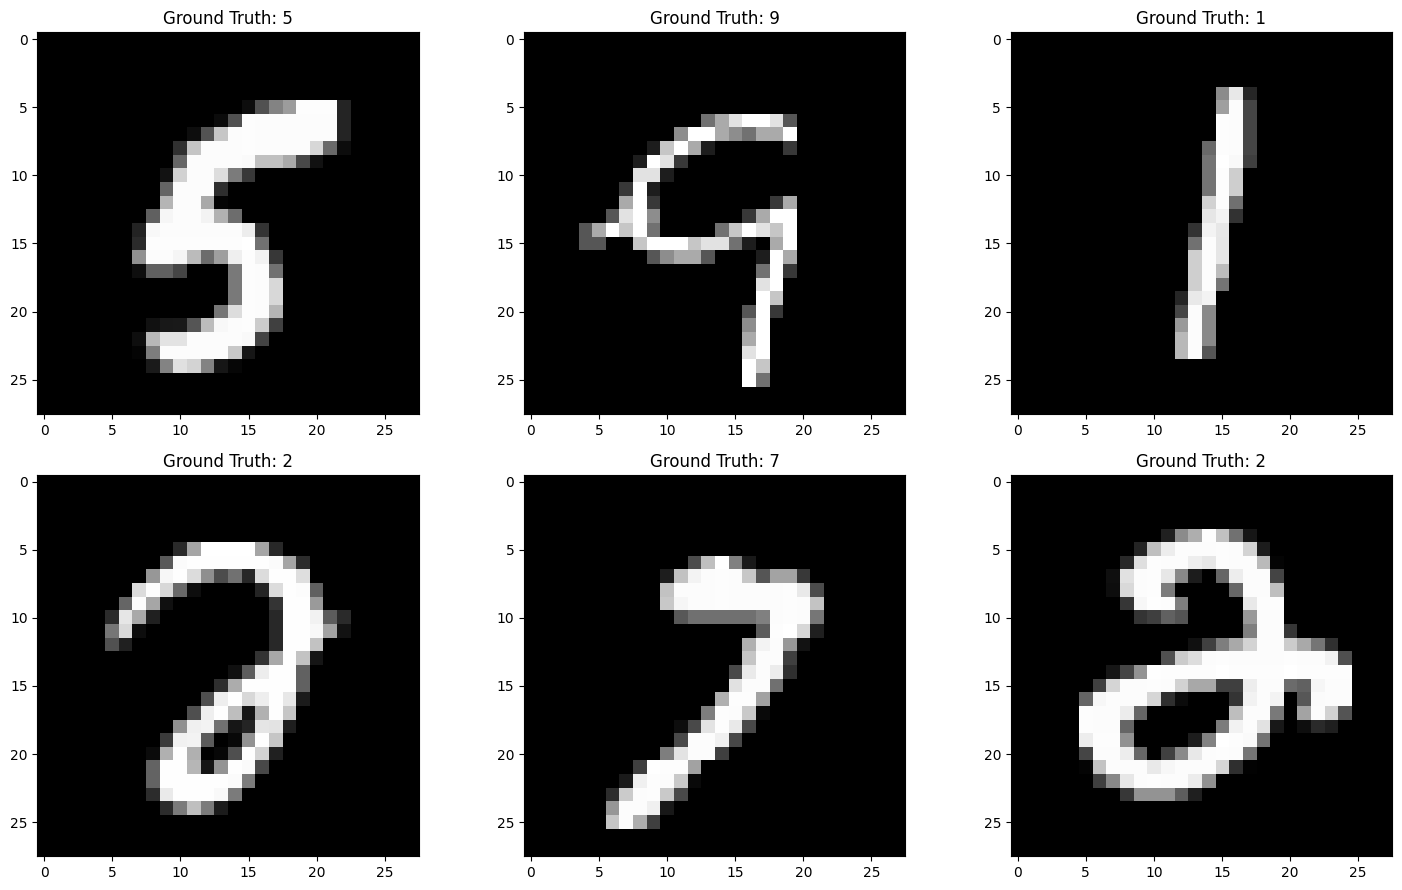

In [2]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

### 2. Model Architecture

In [24]:
class LinearModel(nn.Module):
    def __init__(self,in_dim,out_dim): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=in_dim, out_features=out_dim, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x
    
class MLPModel(nn.Module):
    def __init__(self,in_dim,hid_dim,out_dim,hid_num):
        super(MLPModel,self).__init__()
        #input layer
        self.linear1 = nn.Linear(in_features=in_dim,out_features=hid_dim)
        #hidden layer
        self.linear2 = nn.Linear(in_features=hid_dim,out_features=hid_dim)
        #output layer
        self.linear3 = nn.Linear(in_features=hid_dim,out_features=out_dim)
        #activation function
        self.relu = nn.ReLU()
        #Hidden_layer_num
        self.hid_num = hid_num

    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        for i in range(self.hid_num):
            x = self.linear2(x)
            x = self.relu(x)
        x = self.linear3(x)
        return x

### 3. Cost Function Define (Loss Function Define)  

In [4]:
cls_loss = nn.CrossEntropyLoss()

# Cross Entropy를 테스트해봅시다
test_pred_y = torch.Tensor([[2,0.1],[0,1]])
test_true_y1 = torch.Tensor([1,0]).long()
test_true_y2 = torch.Tensor([0,1]).long()

print(cls_loss(test_pred_y, test_true_y1))
print(cls_loss(test_pred_y, test_true_y2))


tensor(1.6763)
tensor(0.2263)


### 4. Train & Evaluation

In [16]:
# for x,y in train_loader:
#     print(x.squeeze().shape,y.shape)
y.size()

torch.Size([80])

In [18]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = LinearModel(784,10)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.detach().numpy()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        acc = correct.numpy() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Number of 7850 parameters
Epoch: 0, Train Loss: 0.7421675382367791, Val Loss: 0.47948805629452573, Test Acc: 88.32%
Epoch: 1, Train Loss: 0.44017419401946883, Val Loss: 0.40316357755962806, Test Acc: 89.62%
Epoch: 2, Train Loss: 0.39116703221560134, Val Loss: 0.37182278610483, Test Acc: 90.23%
Epoch: 3, Train Loss: 0.3667052629048867, Val Loss: 0.35454450019552736, Test Acc: 90.64%
Epoch: 4, Train Loss: 0.35150817981766314, Val Loss: 0.34210322420053846, Test Acc: 90.89%
Epoch: 5, Train Loss: 0.3403585757440923, Val Loss: 0.3336064785341673, Test Acc: 90.88000000000001%
Epoch: 6, Train Loss: 0.33224652669466365, Val Loss: 0.3267327584797823, Test Acc: 91.09%
Epoch: 7, Train Loss: 0.3258023258212887, Val Loss: 0.3215881925594958, Test Acc: 91.11%
Epoch: 8, Train Loss: 0.32038112445865446, Val Loss: 0.3175148062313659, Test Acc: 91.25999999999999%
Epoch: 9, Train Loss: 0.3156860200569148, Val Loss: 0.31476450570022, Test Acc: 91.32000000000001%
Epoch: 10, Train Loss: 0.3118181498078129, 

### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

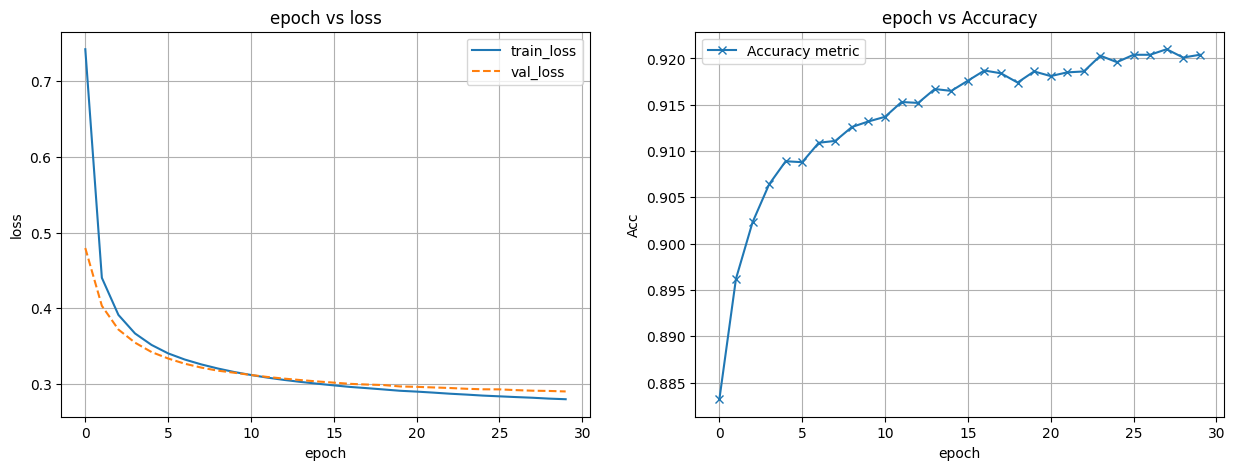

In [19]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()

### MLP model

In [25]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = MLPModel(in_dim=784,hid_dim=256,out_dim=10,hid_num=3)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 15
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.detach().numpy()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        acc = correct.numpy() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Number of 269322 parameters
Epoch: 0, Train Loss: 2.2933798409483925, Val Loss: 2.2807480655139005, Test Acc: 39.76%
Epoch: 1, Train Loss: 2.2517627797773123, Val Loss: 2.202065298828898, Test Acc: 42.21%
Epoch: 2, Train Loss: 1.9502499798679596, Val Loss: 1.4313692744774154, Test Acc: 64.84%
Epoch: 3, Train Loss: 0.8866250425043618, Val Loss: 0.5966768487344815, Test Acc: 83.32000000000001%
Epoch: 4, Train Loss: 0.5116969151112735, Val Loss: 0.4428159179566782, Test Acc: 87.28%
Epoch: 5, Train Loss: 0.41542088329944465, Val Loss: 0.3866597312160685, Test Acc: 88.71%
Epoch: 6, Train Loss: 0.3646304510590975, Val Loss: 0.34478687485562093, Test Acc: 89.81%
Epoch: 7, Train Loss: 0.3290602256879782, Val Loss: 0.3143443501071085, Test Acc: 90.9%
Epoch: 8, Train Loss: 0.30116474087281, Val Loss: 0.2892735913584504, Test Acc: 91.75%
Epoch: 9, Train Loss: 0.27699095178443145, Val Loss: 0.26799346167075483, Test Acc: 92.4%
Epoch: 10, Train Loss: 0.25615116631817025, Val Loss: 0.249514032391053

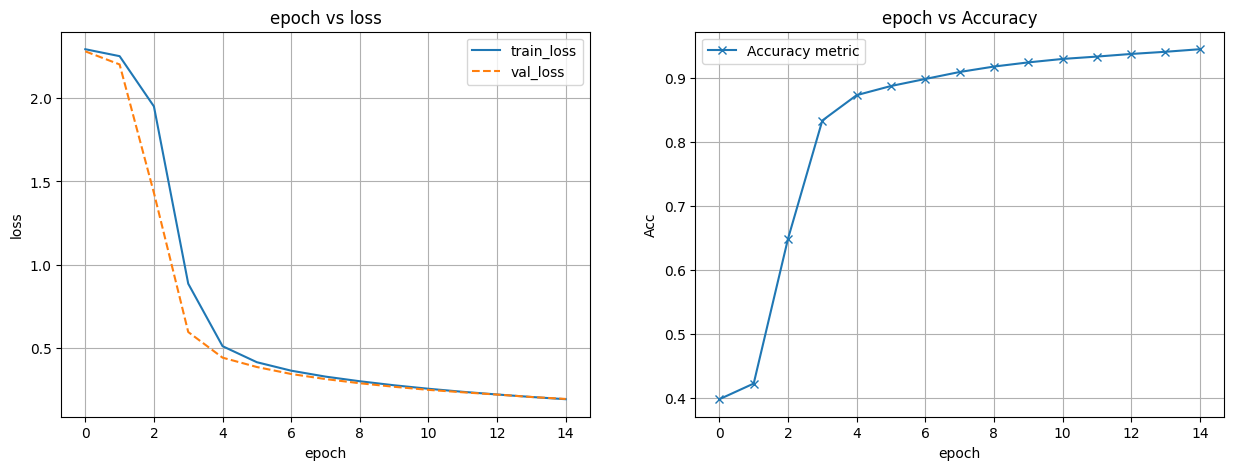

In [26]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()

### 파이토치 내부구조

- 모델을 만들면 자동적으로 parmeter 와 같이 gradient 또한 tensor로 저장함
